<a href="https://colab.research.google.com/github/hongjai-rhee/public/blob/master/%ED%95%98%EC%9D%B4%EC%96%B4%EB%9D%BC%ED%82%A4.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## GLM: Hierarchical Linear Regression

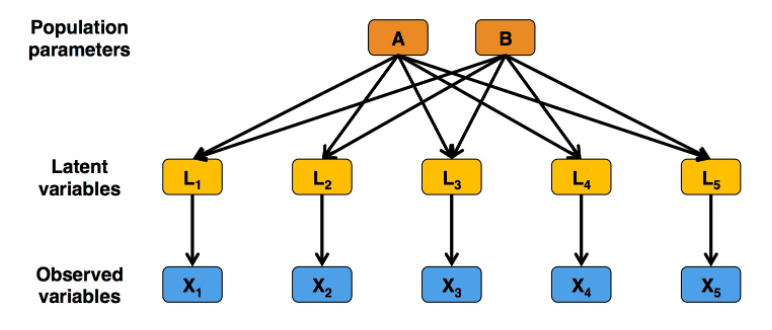

# Set up modules

In [ ]:
!pip install arviz==0.6.1
!pip install pymc3==3.8

import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc3 as pm
import theano

%config InlineBackend.figure_format = 'retina'
az.style.use('arviz-darkgrid')

## The data set¶
Gelman et al.’s (2007) radon dataset is a classic for hierarchical modeling. In this dataset the amount of the radioactive gas radon has been measured among different households in all counties of several states. Radon gas is known to be the highest cause of lung cancer in non-smokers. It is believed to be more strongly present in households containing a basement and to differ in amount present among types of soil. Here we’ll investigate this differences and try to make predictions of radonlevels in different counties based on the county itself and the presence of a basement. In this example we’ll look at Minnesota, a state that contains 85 counties in which different measurements are taken, ranging from 2 to 116 measurements per county.

In [32]:
data = pd.read_csv(pm.get_data('radon.csv'))
data['log_radon'] = data['log_radon'].astype(theano.config.floatX)
county_names = data.county.unique()   # county names 에서 unique 한 것만 뽑아라
county_idx = data.county_code.values  # 카운티 이름을 숫자로 정렬하고, 숫자만 뽑음

n_counties = len(data.county.unique())  # 85개 county

In [38]:
data.rename(columns={'log_radon': 'Y', 'floor': 'X'}, inplace=True)

In [40]:
data[['county','county_code', 'Y', 'X']]

,county,county_code,Y,X
0,AITKIN,0,0.832909,1.0
1,AITKIN,0,0.832909,0.0
2,AITKIN,0,1.098612,0.0
3,AITKIN,0,0.095310,0.0
4,ANOKA,1,1.163151,0.0
...,...,...,...,...
914,WRIGHT,83,1.871802,0.0
915,WRIGHT,83,1.526056,0.0
916,WRIGHT,83,1.629241,0.0
917,YELLOW MEDICINE,84,1.335001,0.0


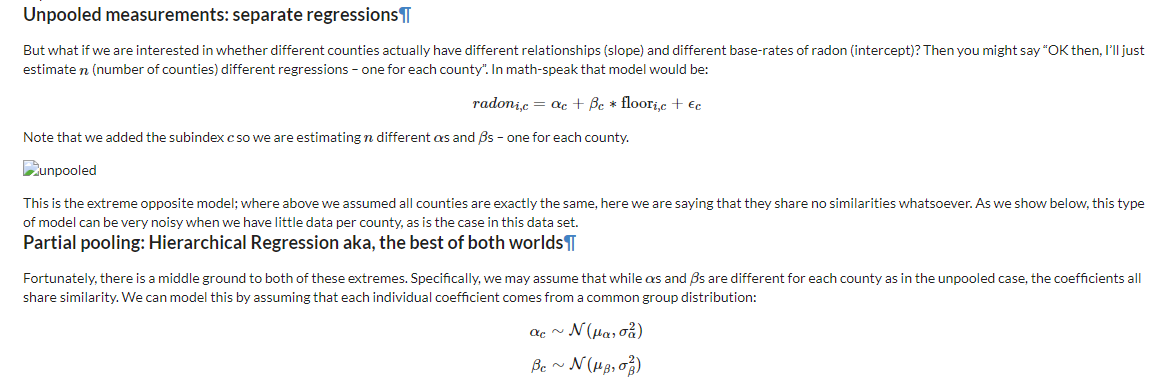

# Separate model 

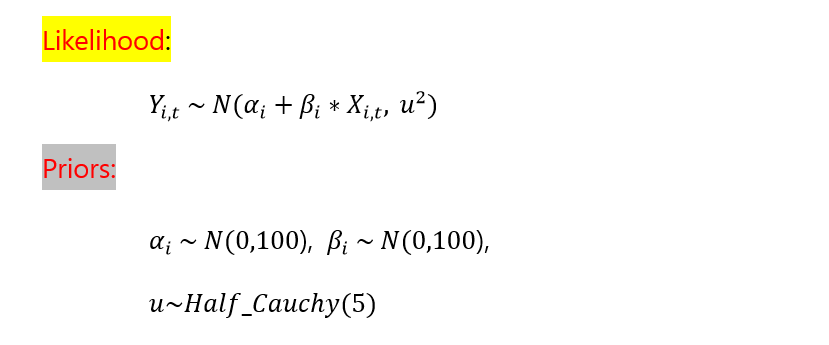

In [45]:
with pm.Model() as unpooled_model:

    # Priors 
    a = pm.Normal('a', 0, sigma=100, shape=n_counties)
    b = pm.Normal('b', 0, sigma=100, shape=n_counties)
    u = pm.HalfCauchy('u', 5)

    y_mean = a[county_idx] + b[county_idx]*data.X.values

    # Data likelihood
    like = pm.Normal('like', y_mean, sigma=u, observed=data.Y)

# 모델 구조 보기

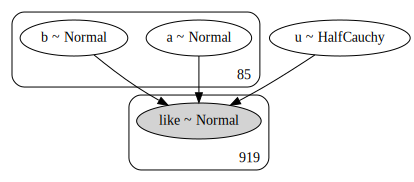

In [53]:
pm.model_to_graphviz(unpooled_model)

# posterior sampling

In [48]:
with unpooled_model:
      trace1 = pm.sample(draws=2000, tune=1000, chains=3)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (3 chains in 1 job)
NUTS: [u, b, a]
Sampling chain 2, 0 divergences: 100%|██████████| 3000/3000 [00:09<00:00, 302.93it/s]


# Graphical Summary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f561b9f0978>,
      dtype=object)

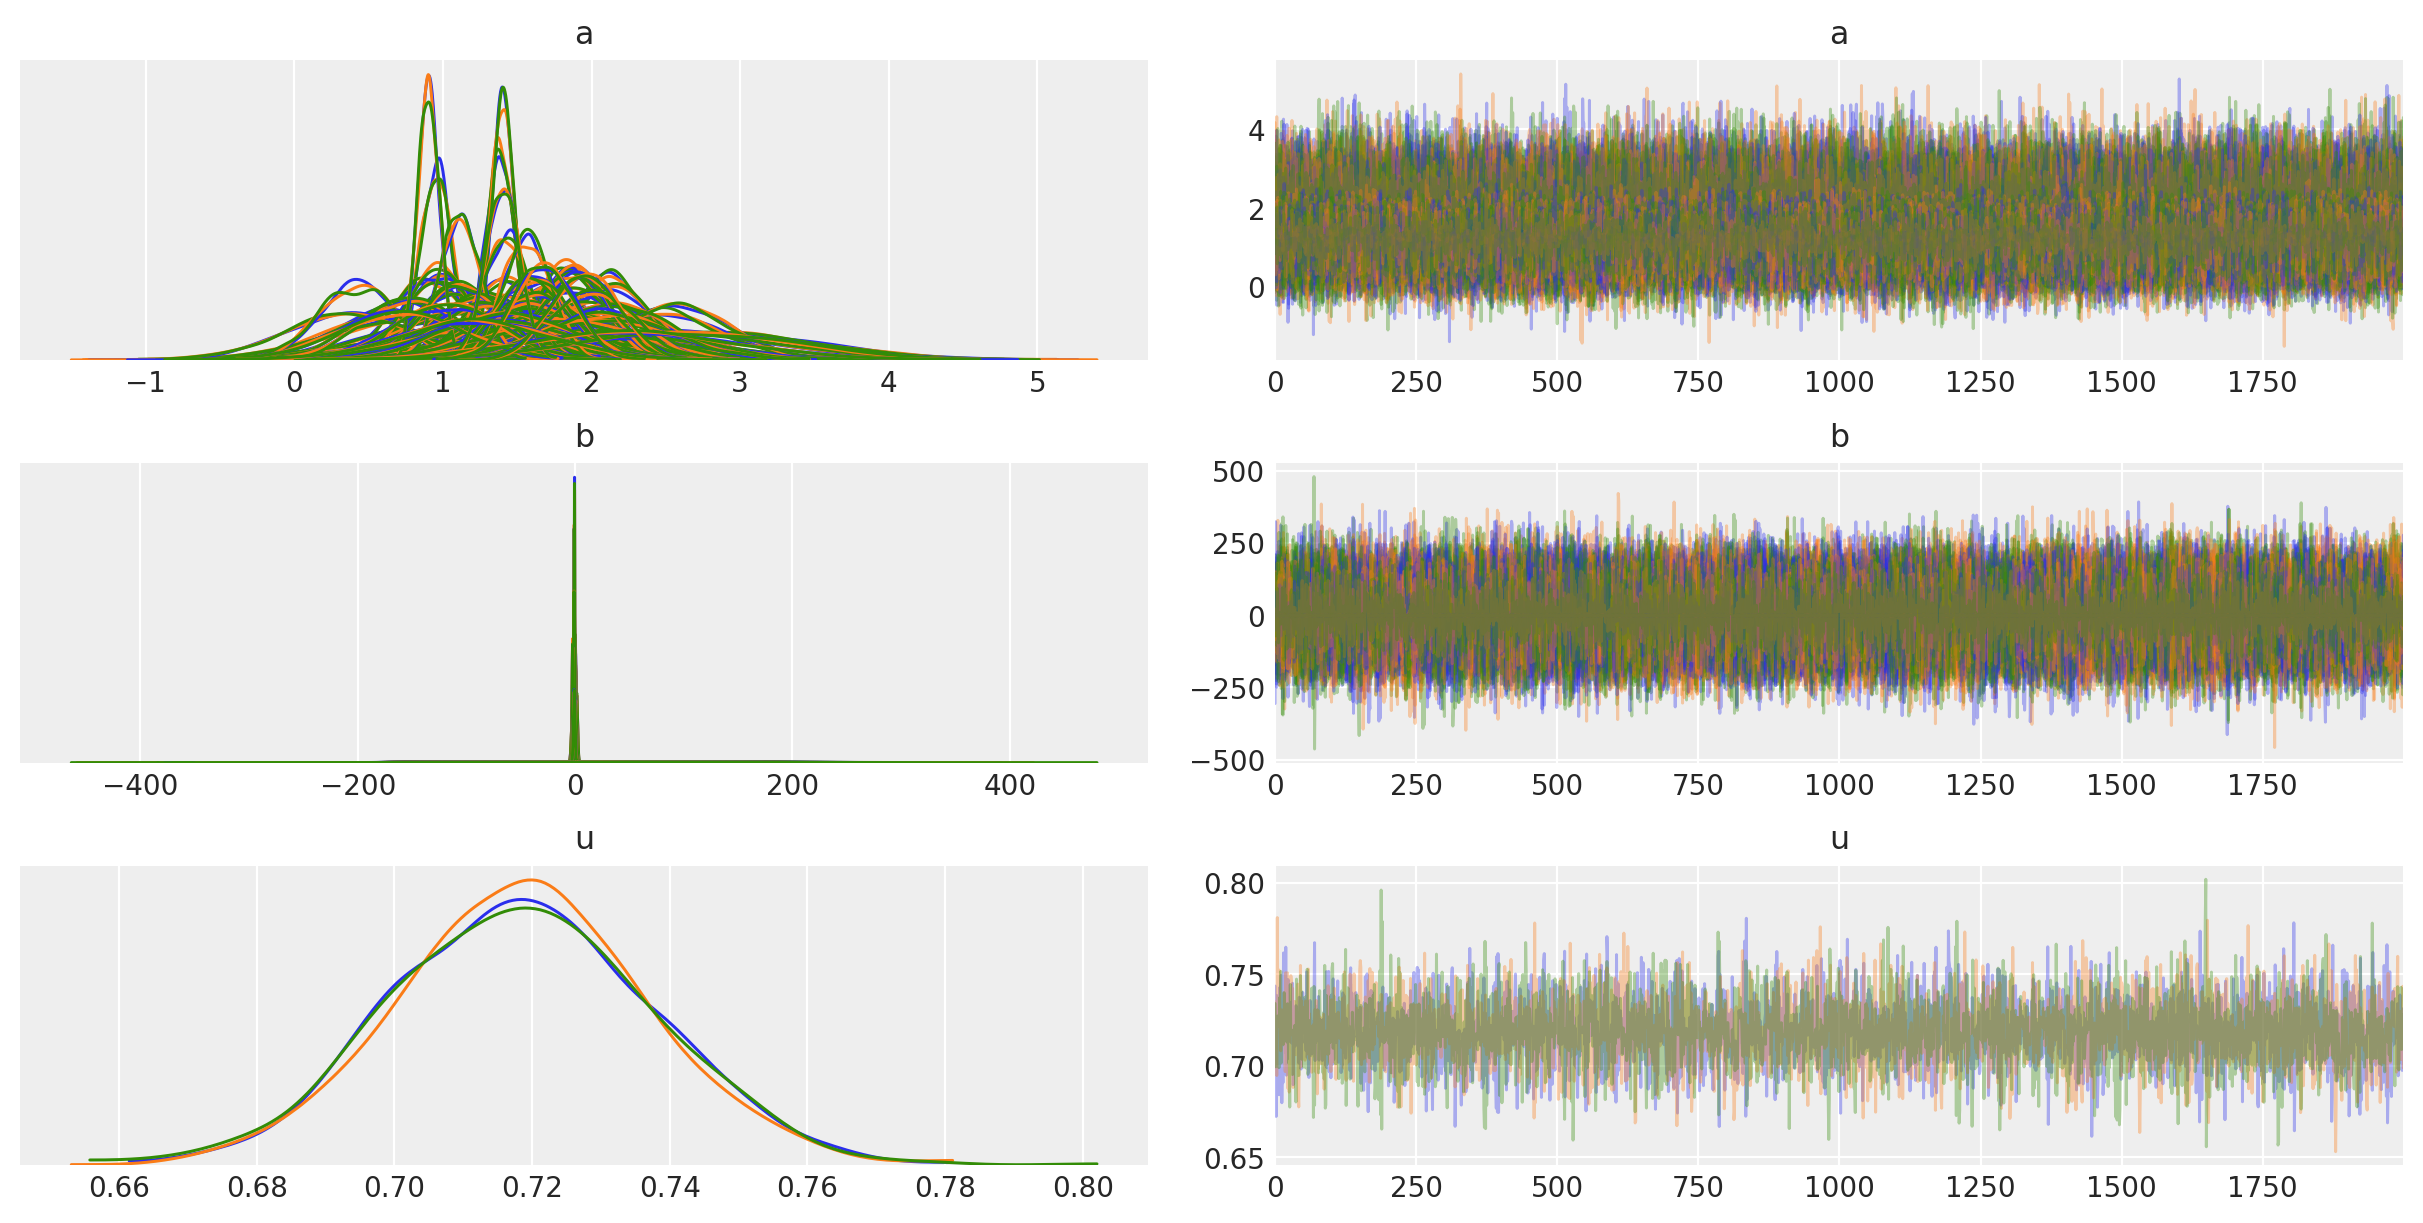

In [49]:
import warnings
warnings.filterwarnings("ignore")

pm.traceplot(trace1)

## Hierarchical Model¶
Instead of creating models separatley, the hierarchical model creates group parameters that consider the countys not as completely different but as having an underlying similarity wuth a common distribution. These distributions are subsequently used to influence the distribution of each county’s α and β.

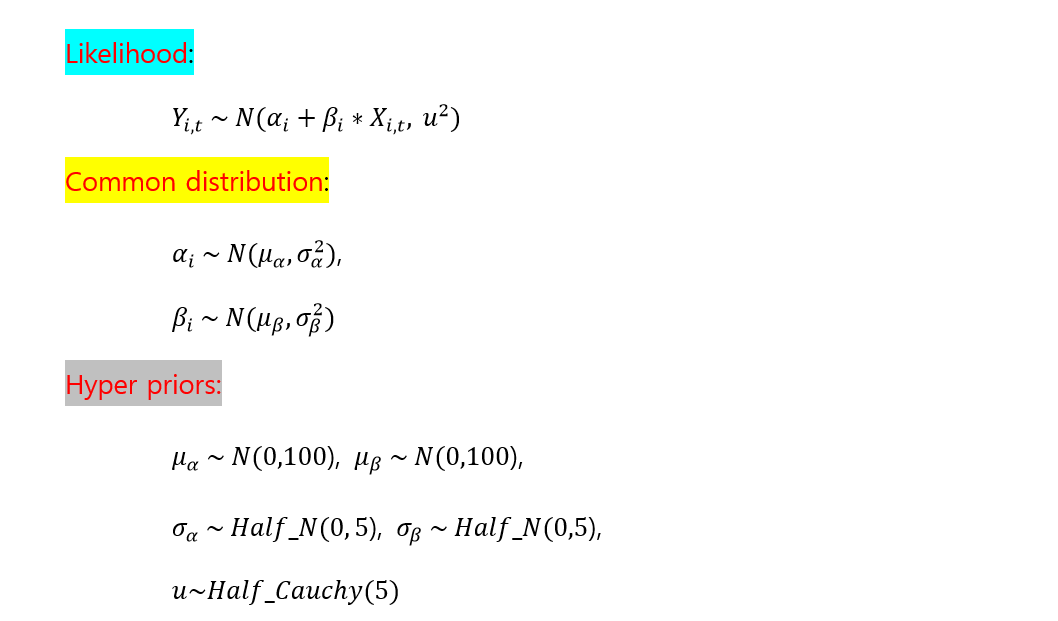

In [50]:
with pm.Model() as hierarchical_model:
  
    # Hyperpriors for group nodes
    mu_a = pm.Normal('mu_a', mu=0., sigma=100)
    sigma_a = pm.HalfNormal('sigma_a', 5.)
    mu_b = pm.Normal('mu_b', mu=0., sigma=100)
    sigma_b = pm.HalfNormal('sigma_b', 5.)

    a = pm.Normal('a', mu=mu_a, sigma=sigma_a, shape=n_counties)   ## county 개수만큼
    b = pm.Normal('b', mu=mu_b, sigma=sigma_b, shape=n_counties)
    # Model error (u)
    u = pm.HalfCauchy('u', 5.)

    y_mean = a[county_idx] + b[county_idx]*data.X.values

    # Data likelihood
    likelihood = pm.Normal('likelihood', mu=y_mean,
                           sigma=u, observed=data.Y)

# 모델 구조 보기

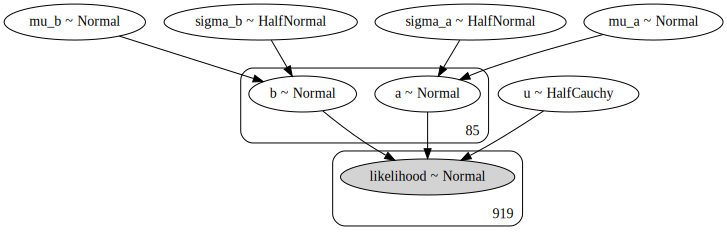

In [55]:
pm.model_to_graphviz(hierarchical_model)

# posterior sampling

In [51]:
with hierarchical_model:
    trace2 = pm.sample(2000, tune=1000, chains=2, target_accept=.9)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Sequential sampling (2 chains in 1 job)
NUTS: [u, b, a, sigma_b, mu_b, sigma_a, mu_a]
Sampling chain 1, 0 divergences: 100%|██████████| 3000/3000 [00:38<00:00, 77.91it/s]
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
There were 15 divergences after tuning. Increase `target_accept` or reparameterize.
The estimated number of effective samples is smaller than 200 for some parameters.


# Graphical Summary

array([[<matplotlib.axes._subplots.AxesSubplot object at 0x7f5619187c88>,
      dtype=object)

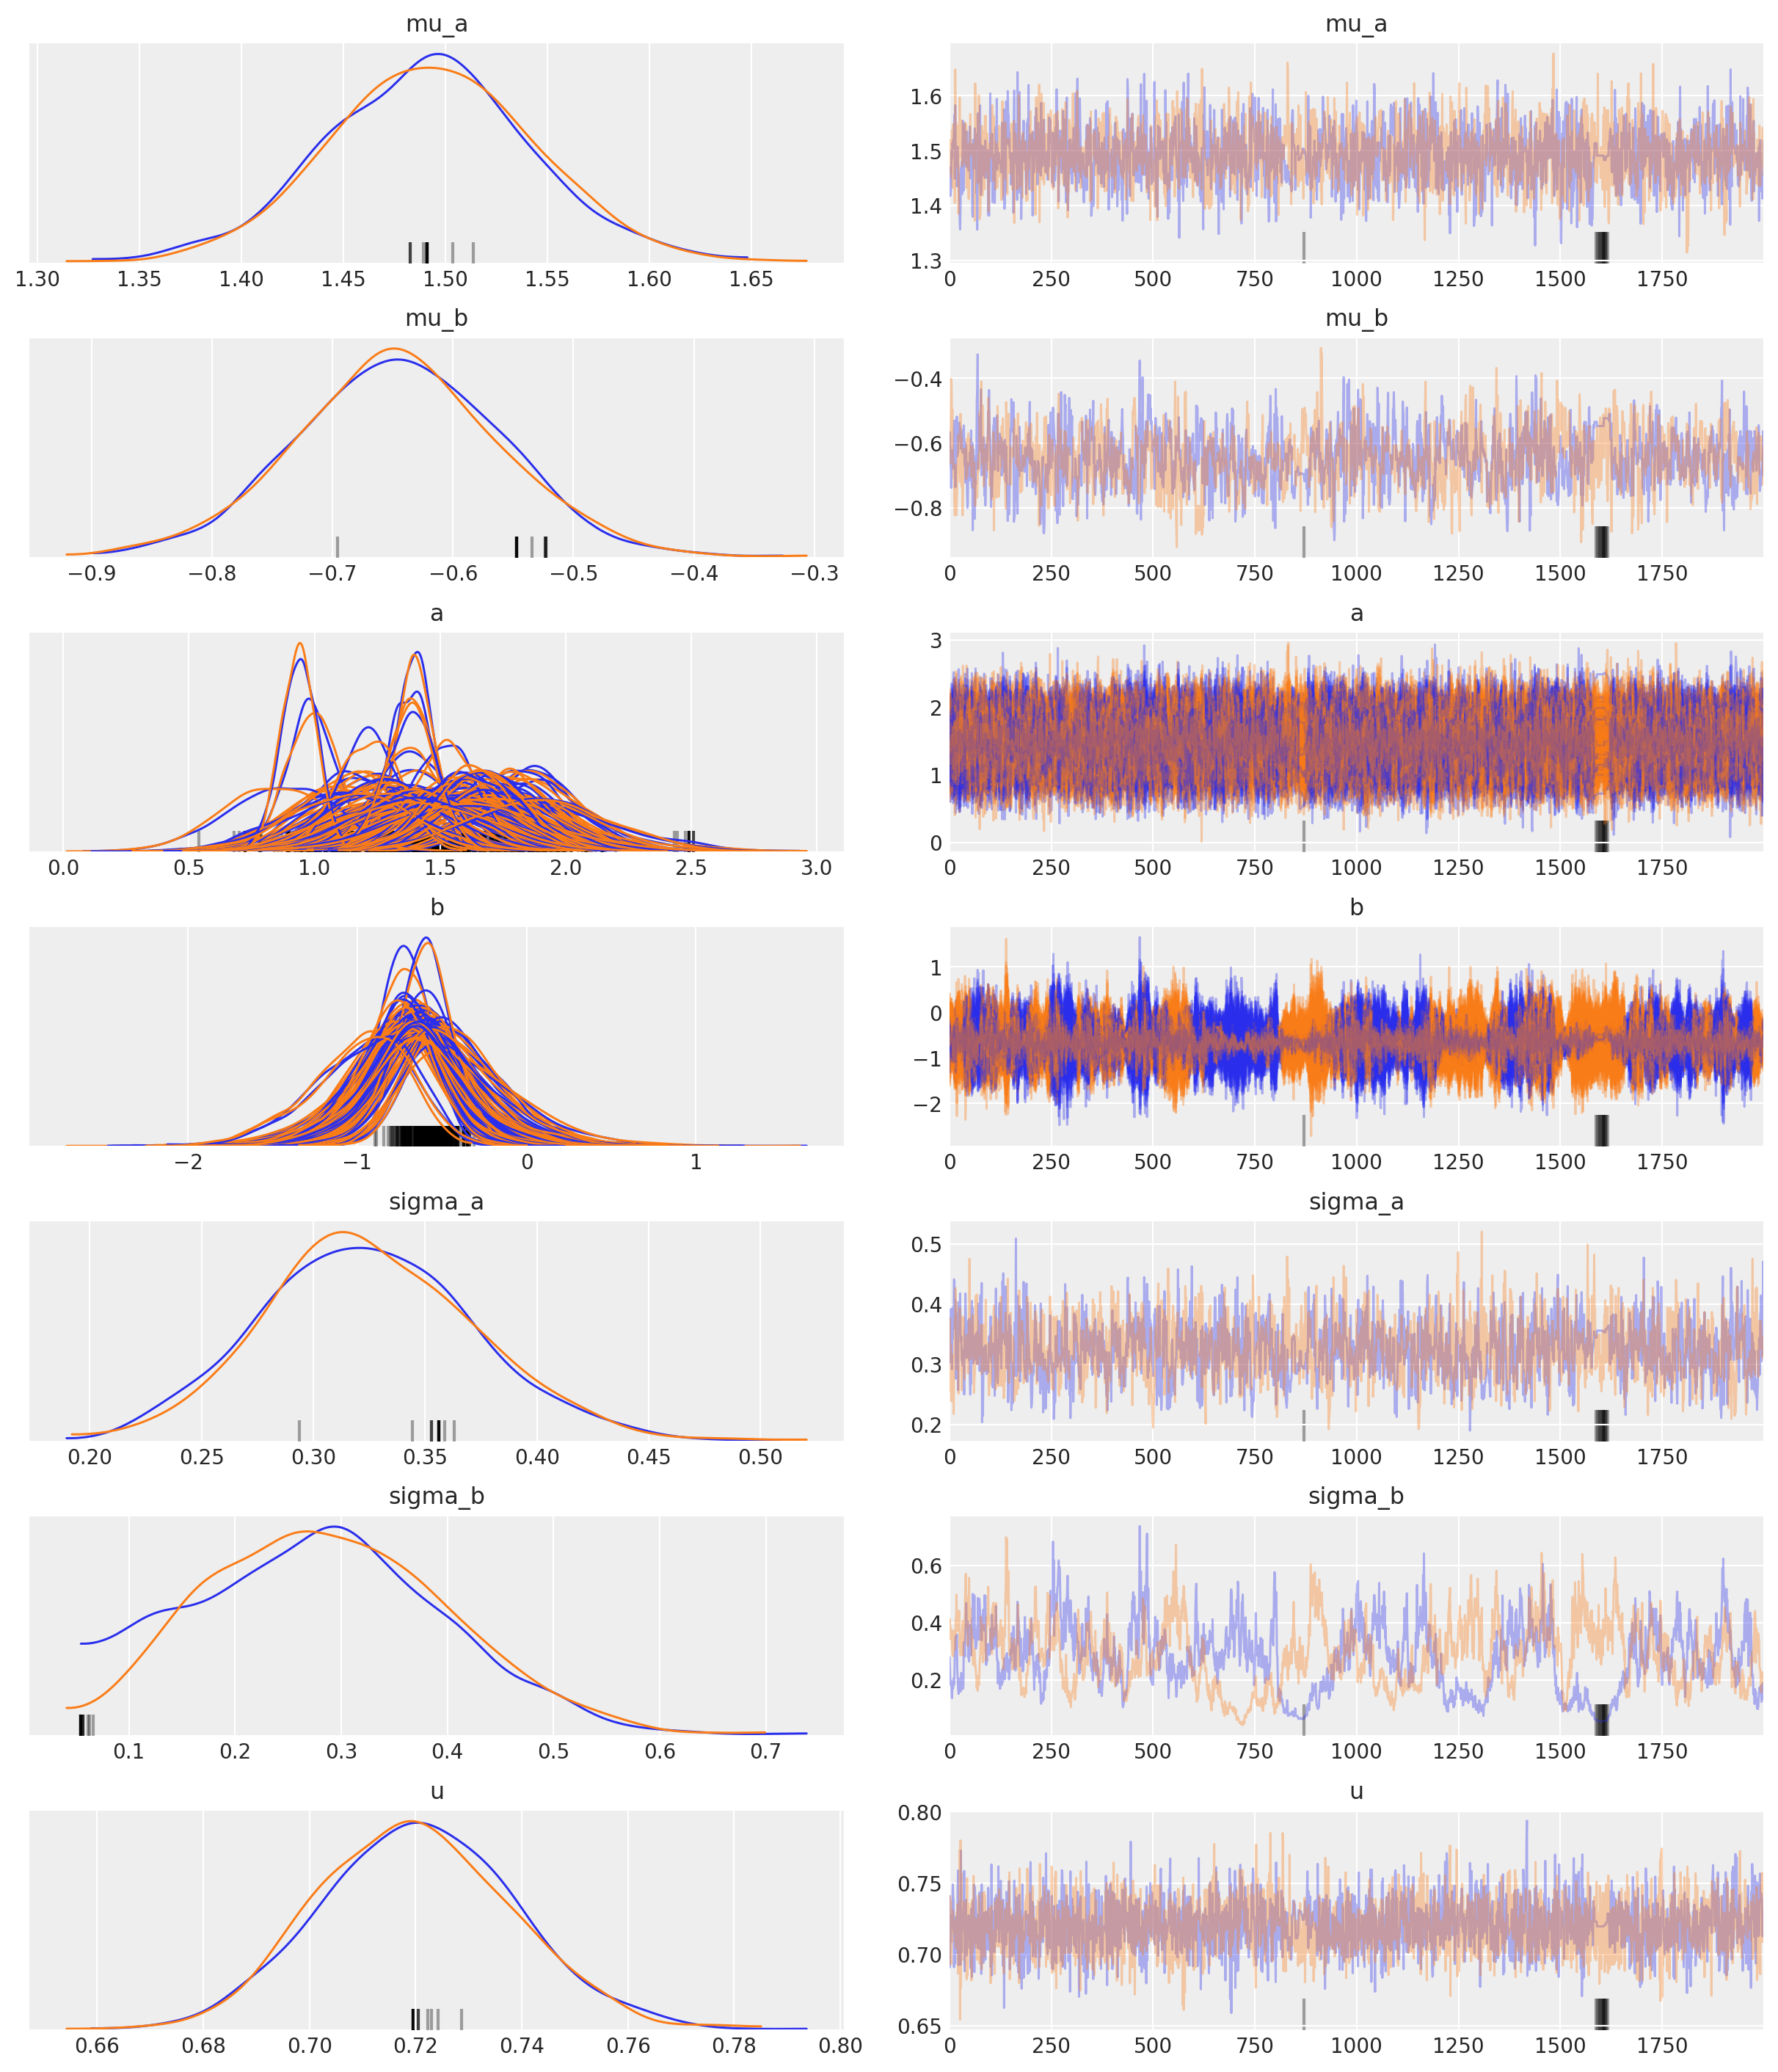

In [52]:
import warnings
warnings.filterwarnings("ignore")

pm.traceplot(trace2)

In [19]:
import warnings
warnings.filterwarnings("ignore")

pm.summary(trace2)

arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shape validation failed: input_shape: (1, 2000), minimum_shape: (chains=2, draws=4)
arviz.stats.stats_utils - WARNING - Shap

,mean,sd,hpd_3%,hpd_97%,mcse_mean,mcse_sd,ess_mean,ess_sd,ess_bulk,ess_tail,r_hat
mu_a,1.491,0.052,1.403,1.598,0.002,0.001,694.0,694.0,689.0,951.0,NaN
mu_b,-0.647,0.082,-0.793,-0.498,0.005,0.003,305.0,305.0,305.0,433.0,NaN
a[0],1.216,0.248,0.725,1.654,0.005,0.004,2182.0,1997.0,2167.0,1524.0,NaN
a[1],0.989,0.098,0.814,1.178,0.002,0.002,1748.0,1656.0,1782.0,1377.0,NaN
a[2],1.505,0.261,0.983,1.980,0.006,0.004,1902.0,1846.0,1934.0,969.0,NaN
...,...,...,...,...,...,...,...,...,...,...,...
b[83],-0.657,0.266,-1.178,-0.169,0.007,0.006,1423.0,1077.0,1397.0,929.0,NaN
b[84],-0.650,0.307,-1.243,-0.111,0.007,0.006,2135.0,1198.0,2042.0,965.0,NaN
sigma_a,0.325,0.046,0.240,0.409,0.002,0.001,548.0,548.0,529.0,583.0,NaN
sigma_b,0.268,0.104,0.077,0.437,0.013,0.009,67.0,67.0,64.0,107.0,NaN
